# IMDb Rating Predicition


## Inhaltsverzeichnis
### 1. Unsere Idee
### 2. Auswahl der Algorithmen
### 3. Die IMDb Datenbank
### 4. Auswahl der Daten
### 5. Formatierung der Daten
### 6. Ergebnisse
### 7. Fazit

## Unsere Idee
Filme sind in der heutigen Zeit aus der Unterhaltungsbranche nicht wegzudenken. Mittlerweile werden durch verschiedene Streaminganbieter eine große Auswahl an Filmen angeboten, die jederzeit geschaut werden können. Einige von den Filmen werden von der Allgemeinheit besser bewertet als andere. Doch woran liegt es, dass einige Filme eine bessere Bewertung von den Zuschauern bekommen? Wir sind ebenfalls große Filmliebhaber. Deswegen haben wir uns gefragt, ob möglicherweise einige Faktoren wie zum Beispiel der Regisseur oder der Schauspieler einen Hinweis darauf liefern können, wie gut ein Film voraussichtlich von der Allgemeinheit bewertet wird.

Deswegen wollen wir mit diesem Projekt herausfinden, ob eine Korrelation zwischen den verschiedenen Daten eines Filmes und der durchschnittlichen Bewertung dessen vorliegt. Falls eine Korrelation besteht, könnte beispielsweise durch die Angabe der Schauspieler, die im Film mit spielen, die durchschnittliche Bewertung des Films hervorgesagt werden. Dadurch wäre es in Zukunft unter anderem möglich zu schauen, welche Schauspieler zusammen einen voraussichtlich guten Film und welche einen eher nicht so gut bewerteten Film drehen würden. Hierbei ist es wichtig herauszufinden, ob und welche Filmdaten überhaupt einen Einfluss auf die Bewertung haben. Außerdem ist die Auswahl eines guten Datensets und Algorithmus wichtig, um die Idee mit Hilfe von Machine Learning umsetzen zu können.

## Auswahl der Algorithmen

Durch die ersten Tests konnten sowohl beim MLP Classifier als auch bei den Decision Tree gute Ergebnisse erzielt werden. In diesem Abschnitt wird die Vorgehensweise der Classifier näher beschrieben.

### MLP Classifier

Der MLP Classifier ist ein neuronales Netz und zählt zu den Supervised Klassifizierungsalgorithmen.  
Ein Neuronales Netz besteht aus verschiedenen Layers. Diese unterteilen sich in Input- Hidden- und Outputlayer. Jedes Layer besteht aus mehreren Neuronen. Jedes Neuron errechnet einen Aktivierungswert, für diesen können verschiedene Funktionen genutzt werden. 
![Alt-Text](Grafiken/neuronalesnetz.png)

Im Inputlayer werden die Daten der verschiedenen Attribute eingegeben. Die Werte dieser werden in das erste Hiddenlayer weiter gegeben. Dabei erhält ein Neuron in dem Hiddenlayer ein Bias von allen Attributen des Inputlayers. In den Neuronen werden nun neue Werte berechnet, welche wiederum an das nächste Hiddenlayer weiter gegeben werden. 
Das letzte Hiddenlayer sendet Werte an das Outputlayer. Im Output Layer befinden sich die zuvor definierten Klassen, nach denen der Input zugeordnet werden kann. 

In einem Supervised Classifier haben alle Inputs ein Label. Dieses Label wird am Ende mit der Outputklasse verglichen. Jenachdem wie diese beiden Faktoren übereinstimmen werden die Neuronen in den Hiddenlayers angepasst. Wenn dieser Vorgang mit allen Inputdaten abgeschlossen ist, ist das Training des Classifiers beendet. 

Der MLP Classifier kann durch verschiedene Faktoren angepasst werden. Zu diesen zählen die Anzahl der Layer und die Anzahl der Neuronen. Ebenfalls kann die Aktivierungsfuntkion des Algoritmus angepasst werden. Für unseren Algorithmus wurde die tanh Funktion (f(x) = tanh(x))  für die Hiddenlayeraktiveierung verwendet, da es die besten Ergebnisse ergeben hat.

### Decision Tree Classifier
Der Decision Tree Classifier ist ebenfalls ein Supervised Klassifizierungsalgorithmus. Hier werden solange einfache Entscheidungen getroffen, bis der Algorithmus den Input eindeutig einer Klasse zuordnen kann. 

Der Algorithmus lernt anhand von Testdaten, wie er welche Entscheidungen treffen muss, um auf das richtige Ergebnis zu kommen. Der Vorteil dieses Algorithmus ist, dass die Daten nicht großartig aufbereitet werden müssen. Zudem ist der Decision Tree einfach zu verstehen und zu visualisieren. 
Ein Decision Tree besteht aus einem Root Node. Diser gibt die erste Entscheidung vor. Nodes erhalten Daten aus einem Node davor oder dem Root Node und geben anhand dessen eine Entscheidung aus. Leafs teilen die Daten nicht weiter auf.

![Alt-Text](Grafiken/decisiontree.png)

### Random Forest Classifier
Der Nachteil der Decision Trees ist, dass mit neuen Daten starke Unterschiede entstehen können. Der Decision Tree neigt zu Overfitting. Dem können Random Forest Classifier entgegenwirken. Hier werden meherere Decision Trees aus unterschiedlichen Teilen der Trainingsdaten erstellt. Anschließend wird eine Abstimmung durchgeführt, um die Ergebnisse zu verbessern.

## Die IMDb Datenbank
Bei der Auswahl des Datensets wurde sich für die IMDb (Internet Movie Database) Datenbank entschieden, da diese die größte öffentlich zugängliche Filmdatenbank ist. In dieser Datenbank können verschiedene Daten zu den Filmen sowie den Personen, die am Film mitgewirkt haben, gefunden werden.
Ein ausgewählter Teil der IMDb Datenbank kann beispielsweise auf Kaggle gefunden werden.
Es handelt sich dabei um eine relationale Datenbank, welche folgende Tabellen enthält:


In [1]:
#%load_ext autoreload
#%reload_ext autoreload
#%matplotlib inline
import database_connector
import main
db = database_connector.DataBase()
tables = db.show_tables()

for table in tables:
    field_info_text = db.get_table_field_info(table)

    print(f"Spalten der Tabelle {table}:")
    print("\t" + ", ".join(field_info_text))


Spalten der Tabelle most_rated_movies:
	primaryTitle, numVotes
Spalten der Tabelle person:
	nconst, primaryName, birthYear, deathYear, primaryProfession, knownForTitles, averageRating
Spalten der Tabelle titleakas:
	titleId, ordering, title, region, language, types, attributes, isOriginalTitle
Spalten der Tabelle titlebasic:
	tconst, titleType, primaryTitle, originalTitle, isAdult, startYear, endYear, runtimeMinutes, genres
Spalten der Tabelle titleprincipals:
	tconst, ordering, nconst, category, job, characters
Spalten der Tabelle titleratings:
	tconst, averageRating, numVotes
Spalten der Tabelle top_rated_movies:
	primaryTitle, startYear, averageRating, numVotes
Spalten der Tabelle valid_movies:
	tconst, primaryTitle, startYear, runtimeMinutes, genres, averageRating, numVotes


Viele Einträge sind allerdings fehlerhaft oder unvollständig, weswegen es wichtig ist, diese zu filtern und nur die relevanten Daten zu verwenden.

Die Tabelle Titlebasic beinhaltet alle Titel und ist 5 Millionen Einträge groß:

In [2]:
db.sql("SELECT COUNT(*) FROM titlebasic")[0]

(5701079,)

Die IMDb Datenbank enthält allerdings nicht nur Daten zu Filmen, sondern auch zu Serien. Deswegen müssen die 5 Millionen Einträge nach dem Typ Film gefiltert werden. Dadurch kommen wir auf ungefähr 500.000 Einträge:

In [3]:
db.sql("SELECT COUNT(*) FROM titlebasic WHERE titleType = 'Movie'")[0]

(509332,)

Unter diesen 500.000 Filmen sind einige, die keine Bewertung haben. Diese müssen ebenfalls herausgefiltert werden, wodurch 200.000 Einträge übrig bleiben:


In [4]:
db.sql("SELECT COUNT(*) FROM titlebasic inner join titleratings on titleratings.tconst = titlebasic.tconst where titleType = 'Movie'")[0]

(237738,)

Davon haben nur 3000 Einträge mehr als 50000 Bewertungen, ein Wert bei welchem wir festgestellt haben, dass die Bewertungen eine ausreichende Aussagekraft besitzen.

In [5]:
db.sql("SELECT COUNT(*) FROM titlebasic inner join titleratings on titleratings.tconst = titlebasic.tconst where titleType = 'Movie' AND titleratings.numVotes > 50000")[0]


(3023,)

Das sind die Filme, die in der view "Valid_Movies" dargestellt werden.

In [6]:
db.sql("SELECT primaryTitle, startYear, runtimeMinutes, genres FROM imdb.valid_movies order by startYear DESC limit 8")

[('The Pancake Ghost', 2021, 0, 'Musical'),
 ('Mayday', 2020, 0, 'Drama'),
 ('Aladdin', 2019, 128, 'Adventure,Family,Fantasy'),
 ('Glass', 2019, 129, 'Drama,Sci-Fi,Thriller'),
 ('Yesterday', 2019, 116, 'Comedy,Fantasy,Music'),
 ('Toy Story 4', 2019, 100, 'Adventure,Animation,Comedy'),
 ('Joker', 2019, 122, 'Crime,Drama,Thriller'),
 ('Parasite', 2019, 132, 'Comedy,Drama,Thriller')]

Wenn die View "Valid_Movies" nach der Bewertung sortiert wird fällt auf, dass die Liste der best bewertesten Filme auf der IMDb Website dieser ähnelt, weswegen davon ausgegangen werden kann, dass die IMDb ähnliche Filter anwendet.

In [7]:
db.get_top_rated_movies()

[('The Shawshank Redemption', 1994, 9.3, 2159745),
 ('The Godfather', 1972, 9.2, 1482225),
 ('The Godfather: Part II', 1974, 9.0, 1032110),
 ('The Dark Knight', 2008, 9.0, 2134602),
 ('The Mountain II', 2016, 9.0, 101817),
 ('12 Angry Men', 1957, 8.9, 617607),
 ("Schindler's List", 1993, 8.9, 1120297),
 ('Pulp Fiction', 1994, 8.9, 1695159),
 ('The Lord of the Rings: The Return of the King', 2003, 8.9, 1533632),
 ('The Good, the Bad and the Ugly', 1966, 8.8, 640941),
 ('Forrest Gump', 1994, 8.8, 1662609),
 ('The Lord of the Rings: The Fellowship of the Ring', 2001, 8.8, 1548920),
 ('Fight Club', 1999, 8.8, 1725444),
 ('Inception', 2010, 8.8, 1892958),
 ('Joker', 2019, 8.8, 466912),
 ("One Flew Over the Cuckoo's Nest", 1975, 8.7, 852798),
 ('Star Wars: Episode V - The Empire Strikes Back', 1980, 8.7, 1078754),
 ('Goodfellas', 1990, 8.7, 933687),
 ('The Matrix', 1999, 8.7, 1554345),
 ('The Lord of the Rings: The Two Towers', 2002, 8.7, 1387208),
 ("It's a Wonderful Life", 1946, 8.6, 36675

## Auswahl der Daten
Da wir nun die Auswahl der Datensätze getroffen haben, geht es nun darum, Attribute auszuwählen, die für das neurale Netzwerk genutzt werden können. Das Attribut `titleType` macht hierbei keinen Sinn, da es sich eh nur um Filme handelt. Daher wird auch das `endYear` ignoriert, da bei einem Film das Attribut keinen Wert hat. Ebenso interessiert uns der `originalTitle` für das Rating nicht genau so wie das Attribut `isAdult`. Alle anderen Attribute dagegen werden benötigt.

In [8]:
movies = main.loadDataBase()
inception = movies[2213]
print(f"ID\t\t{inception.id}\nTitel\t\t{inception.title}\nJahr\t\t{inception.startYear}\nLaufzeit\t{inception.runtimeMinutes}\nGenres\t\t{inception.genres}\nAverage Rating\t{inception.averageRating}\nNumber of Votes\t{inception.numVotes}")

Loading Database...
100.0% 	 Time elapsed: 0:00:01.707s
Database loaded.
ID		tt1375666
Titel		Inception
Jahr		2010
Laufzeit	148
Genres		['Action', 'Adventure', 'Sci-Fi']
Average Rating	8.8
Number of Votes	1892958


In [9]:
crew = inception.actors
print("%-25s %-10s %-4s %20s" % ("Name", "Bewertung","Nummer", "Rolle  "))
for person in crew:
    print ("%-25s %-10s %-4s %20s" % (person.getName(),person.rating, person.ordering,person.category))

Name                      Bewertung  Nummer              Rolle  
Leonardo DiCaprio         7.28       1                   actor
Joseph Gordon-Levitt      7.2        2                   actor
Ellen Page                7.2        3                 actress
Ken Watanabe              7.5        4                   actor
Christopher Nolan         8.08       5                director
Emma Thomas               8.28       6                producer
Hans Zimmer               7.02       7                composer
Wally Pfister             7.83       8         cinematographer
Lee Smith                 8.35       9                  editor
Guy Hendrix Dyas          8.8        10    production_designer


## Formatierung der Daten
Nachdem die Daten aus der Datenbank in das Python Programm geladen wurden, liegen sie als Objekte im Speicher. Da die ausgesuchten Algorithmen keine relationalen Objektdaten verarbeiten können, müssen diese in Vektoren eiener konstanten Dimension umformatiert werden. Die einschränkungen des IMDb Datensatzes kamen uns dabei entgegen. <br>
Das größte Problem war dabei die umkonvertierung der kategorischen Daten zu numerischen Werten. Die Werte `startYear`, `runtime`, `numberOfVotes` und (Länge des) `title` waren schon numerisch, weshalb diese direkt in den Vektor aufgenommen werden können. <br>
Dann gibt es noch Daten, welche rein Kategorisch sind und nicht sinnvoll auf einer numerischen Skala festgelegt werden können: `genre`,`nconst`,`category`<br>

Für Genre und Category werden jeweils ein One-Hot Encoder benutzt. Dieser erzeugt für n Kategorien ein Bitarray der größe n, bei welchem die Kategorie die einzige 1 ist. Hier ein simples Beipsiel:

In [10]:
from sklearn import preprocessing
categories = ["Stark","Lannister","Baratheon","Martell"]
lb = preprocessing.LabelBinarizer()
lb.fit_transform(categories)

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0]])

Anschließend kann ein beliebiges Label in ein Bitarray transformiert werden

In [11]:
lb.transform(["Lannister"])

array([[0, 1, 0, 0]])

Wie zu sehen ist, eignet sich es nicht für eine große Anzahl von Labels, da das Array dabei sehr groß werden würde. Da es jedoch nur 23 Genres und 11 Categories (Rollen) gibt, eignet sich das One-Hot Encoding für diese Daten gut. Da in der IMDb Datenbank ein Film höchstens drei Genres haben kann und dank dass One-Hot Encoding diese drei Arrays zusammenaddiert werden können, müssen für die Genres nur 23 Features hinzugefügt werden. <br>
Eine weitere Einschränkung unseres Datensatzes ist es, dass pro Film maximal 10 Schauspieler/Crew eingetragen sind. Das erleichtert das Arbeiten mit dem Algorithmus, da wir immer eine feste Anzahl an Schauspielern mitgeben. Da es 12000 mögliche Schauspieler (nconst) gibt, ist hier ein One-Hot Encoding nicht sinnvoll.<br>
Für den Schauspieler wird deshalb ein LabelEncoder verwendet, welcher jedem Schauspieler eine Nummer zuordnet.

In [12]:
lb = preprocessing.LabelEncoder()
lb.fit_transform(categories)

array([3, 1, 0, 2], dtype=int64)

In [13]:
lb.transform(["Lannister"])

array([1], dtype=int64)

Für jeden Film werden demnach die Features <br>
* Länge des Titels
* startYear
* runtime
* numberOfVotes
* 23x Genres
* 10x
    * Schauspieler ID (später durchschnittl. Bewertung)
    * ordering
    * 11x Category (Rolle)

Das Array welches in den Algorithmus übergeben wird, ist 157 Features (Attribute) groß.

## Ergebnisse

Mit den oben genannten Attributen wurden drei Algorithmen Trainiert, um zu sehen, welcher besser geeignet ist. Diese Algorithmen waren der MLPClassifier, Decision Tree Classifier und Random Forest Classifier von Sklearn. Die Klassen sind die verschiedenen (ganzzahligen) Ratings, die ein Film haben kann. Wir unterteilten dabei unseren Datensatz in 70% Trainings und 30% Testdaten. Wir erhielten Testscores zwischen ~70-80%.

### Der Predictor
Zunächst werden alle Filme aus der Datenbank geladen.

In [14]:
import database_connector
import ratingPredictor

allMovies = main.loadDataBase()

Loading Database...
100.0% 	 Time elapsed: 0:00:01.652s
Database loaded.


Nun wird der Rating Predictor, also unser Decision Tree/Neurales Netwerk erzeugt und trainiert sich an den Daten allMovies.

In [15]:
nrater = ratingPredictor.ratingPredictor(allMovies)
trater = ratingPredictor.ratingPredictor(allMovies)
frater = ratingPredictor.ratingPredictor(allMovies)

Mit algorithm kann der Algortihmus ausgewählt werden, der genutzt werden soll: neural, tree oder forest

In [16]:
clf_neural = nrater.learn(algorithm='neural') 

Converting data...
100.0% 	 Time elapsed: 0:00:09.648s
Data converted.
Training started...
Training done.
Test score is:
0.7166482910694597


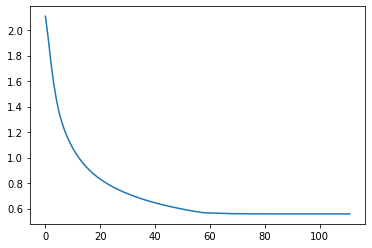

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(clf_neural.loss_curve_)

In [18]:
clf_tree = trater.learn(algorithm='tree') 

Converting data...
100.0% 	 Time elapsed: 0:00:09.449s
Data converted.
Training started...
Training done.
Test score is:
0.7574421168687983


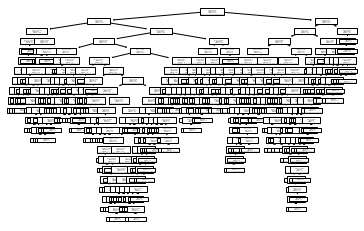

In [19]:
import matplotlib
from sklearn import tree
tree.plot_tree(clf_tree)
plot = plt.show()

In [20]:
clf_forest = frater.learn(algorithm='forest')

Converting data...
100.0% 	 Time elapsed: 0:00:09.649s
Data converted.
Training started...
Training done.
Test score is:
0.804851157662624


<BarContainer object of 9 artists>

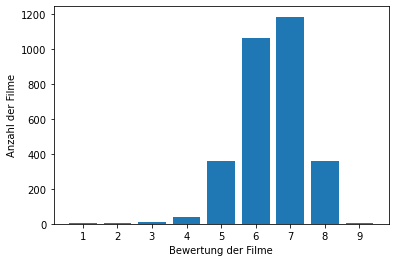

In [21]:
plt.ylabel('Anzahl der Filme')
plt.xlabel('Bewertung der Filme')
x = [1,2,3,4,5,6,7,8,9]
plt.xticks(x)
x, y = nrater.plot_ratings()
plt.bar(x,y)

Text(0.5, 1.0, 'Neural Network')

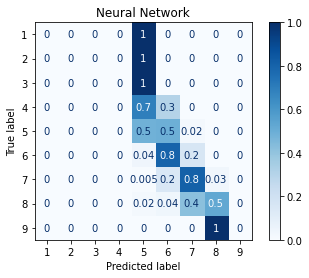

In [22]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
#disp = plot_roc_curve(clf, rater.x_test, rater.y_test)
disp1 = plot_confusion_matrix(clf_neural, nrater.x_test, nrater.y_test,
                                 display_labels=[1,2,3,4,5,6,7,8,9],
                                 cmap='Blues',
                                 normalize='true',
                                values_format='.0g')
disp1.ax_.set_title('Neural Network')

Text(0.5, 1.0, 'Decision Tree')

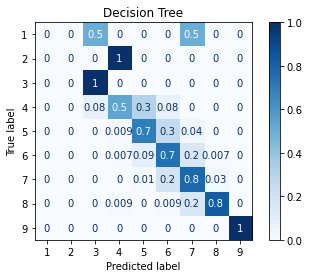

In [23]:
disp2 = plot_confusion_matrix(clf_tree, trater.x_test, trater.y_test,
                                 display_labels=[1,2,3,4,5,6,7,8,9],
                                 cmap='Blues',
                                 normalize='true',
                                values_format='.0g')
disp2.ax_.set_title('Decision Tree')

Text(0.5, 1.0, 'Random Forest Classifier')

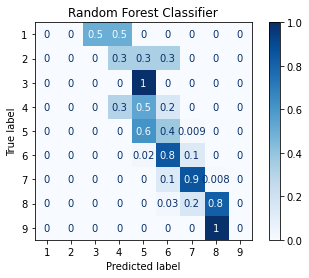

In [24]:
disp3 = plot_confusion_matrix(clf_forest, frater.x_test, frater.y_test,
                                 display_labels=[1,2,3,4,5,6,7,8,9],
                                 cmap='Blues',
                                 normalize='true',
                                values_format='.0g')
disp3.ax_.set_title('Random Forest Classifier')

In [25]:
from sklearn.metrics import classification_report
y_pred, y_true = nrater.predictAllTestValues()
print("\t\t\tNeural Network\n" +classification_report(y_true, y_pred, zero_division = 0))

			Neural Network
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        13
           5       0.63      0.49      0.55       109
           6       0.67      0.80      0.73       298
           7       0.76      0.81      0.78       370
           8       0.82      0.53      0.64       110
           9       0.00      0.00      0.00         1

    accuracy                           0.72       907
   macro avg       0.32      0.29      0.30       907
weighted avg       0.70      0.72      0.70       907



In [26]:
y_pred, y_true = trater.predictAllTestValues()
print("\t\t\tDecision Tree\n" +classification_report(y_true, y_pred, zero_division = 0))

			Decision Tree
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.33      1.00      0.50         1
           4       0.50      0.54      0.52        13
           5       0.68      0.70      0.69       109
           6       0.70      0.75      0.72       298
           7       0.81      0.78      0.79       370
           8       0.88      0.83      0.85       110
           9       1.00      1.00      1.00         1

    accuracy                           0.76       907
   macro avg       0.55      0.62      0.56       907
weighted avg       0.76      0.76      0.76       907



In [27]:
y_pred, y_true = frater.predictAllTestValues()
print("\t\t\tRandom Forest Classifier\n" +classification_report(y_true, y_pred, zero_division = 0))

			Random Forest Classifier
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.67      0.31      0.42        13
           5       0.81      0.61      0.70       109
           6       0.72      0.85      0.78       298
           7       0.85      0.86      0.85       370
           8       0.96      0.82      0.88       110
           9       0.00      0.00      0.00         1

    accuracy                           0.80       907
   macro avg       0.44      0.38      0.40       907
weighted avg       0.81      0.80      0.80       907



In [28]:
from sklearn.metrics import roc_auc_score
print("Neural Network\n")
roc_auc_score(nrater.y_test,clf_neural.predict_proba(nrater.x_test),multi_class='ovr')

Neural Network



0.7376484699129093

In [29]:
print("Decision Tree\n")
roc_auc_score(trater.y_test,clf_tree.predict_proba(trater.x_test),multi_class='ovr')

Decision Tree



0.7909268985973886

In [30]:
print("Random Forest Classifier\n")
roc_auc_score(frater.y_test,clf_forest.predict_proba(frater.x_test),multi_class='ovr')

Random Forest Classifier



0.9765204010262258

### Demo
Nun kann dieser RatingPredictor auch Bewertungen von Filmen vorhersagen. Dazu können wir uns anschauen, welche Möglichkeiten wir haben, einen Film zu erstellen.

In [31]:
frater.getAllRoles()

['actor',
 'actress',
 'director',
 'writer',
 'composer',
 'producer',
 'cinematographer',
 'editor',
 'self',
 'production_designer',
 'archive_footage']

Dies sind alle Rollen, die ein Schauspieler/Crew haben kann. Diese müssen auch genau so geschrieben werden, damit sie erkannt werden.

In [32]:
frater.getAllGenres()

['Fantasy',
 'Horror',
 'Mystery',
 'Comedy',
 'Drama',
 'Family',
 'Adventure',
 'Sci-Fi',
 'Action',
 'War',
 'Romance',
 'Crime',
 'Thriller',
 'Musical',
 'Animation',
 'History',
 'Film-Noir',
 'Western',
 'Music',
 'Biography',
 'Sport',
 'Documentary',
 'News']

Dies sind alle Genres, die ein Film haben kann. Ein Film kann bis zu drei Genres haben, braucht jedoch nur eins.

Ein Film kann nach dem Schema (Titel(String), Veröffentlichungsjahr(int), Laufzeit(int), Genre1(String), Genre2(String), Genre3(String), Anzahl der Bewertungen(int)) erzeugt werden. Anschließend können schauspieler mit der Funktion addCrewByName hinzugefügt werden, mit dem Schema (Name(String), Rolle(String))

In [33]:
newMovie = main.createMovie("Mein neuer Film",2000,120,"Action","Crime","War",100000)
newMovie.addCrewByName("Johnny Depp", "actor")
newMovie.addCrewByName("Christian Bale", "actor")
newMovie.addCrewByName("Michael Bay","director")
newMovie.addCrewByName("John Williams", "composer")
newMovie.addCrewByName("Christopher Nolan", "director")
newMovie.addCrewByName("Marlon Brando","actor")
newMovie.addCrewByName("Ryan Reynolds","actor")
newMovie.getAsString()

"Mein neuer Film (2000) Länge: 120min Genres: ['Action', 'Crime', 'War'] Bewertung: 0 mit 100000 Bewertungen. Mit ['Johnny Depp', 'Christian Bale', 'Michael Bay', 'John Williams', 'Christopher Nolan', 'Marlon Brando', 'Ryan Reynolds']"

Nun kann der RatingPredictor das Rating vorhersagen

In [34]:
frater.predictMovie(newMovie)

Converting data...
100.0% 	 Time elapsed: 0:00:00.002s
Data converted.


array([7])

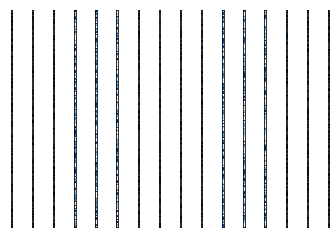

In [35]:
fig, axes = plt.subplots(1, 16)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = clf_neural.coefs_[0].min(), clf_neural.coefs_[0].max()
for coef, ax in zip(clf_neural.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(157,1), cmap='Blues', vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

# Fazit

Wir können mit einer Wahrscheinlichkeit von etwa 80% die Bewertung eines Filmes voraussagen. Dieser Score ist nicht so hoch wie andere Machine Learning Projekte, was dafür spricht, dass ein Film auch an anderen Merkmalen, wie dem Inhalt, der Story (alle Attribute, welche wir nicht überprüfen können) bewertet wird. Jedoch kann schon von äußerlichen Merkmalen die Bewertung teilweise vorhergesagt werden.

Besonders bei sehr "schlechten" oder sehr "guten" Filmen hat der Algorithmus schwierigkeiten, da hier so wenig Trainingsdaten verfügbar waren. Der Datensatz war deshalb nicht besonders divers, da die meisten Filme eine Bewertung zwischen 6 und 8 hatten und nur sehr wenige außerhalb lagen. Wenn man hier mehr Daten bekommen könnte, würden wir erwarten, dass der Algorithmus auch diese Bewertungen besser vorhersagt.

Bei manuellen Test konnte herausgefunden werden, welche Attribute welchen Einfluss auf die Bewertung haben:
* Filmnamelänge: Kurz eher schelchter, länger eher besser
* Jahr: Kaum Auswirkung, außer im Extrembereich
* Filmlänge: Kaum Auswirkung
* Anzahl der Bewertungen: Je mehr, desto besser


# Vielen Dank